In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn import preprocessing 
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline
np.set_printoptions(suppress=True, formatter={'float_kind':'{:f}'.format})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('use_inf_as_na', True)
from google.colab import files

NON_FRAUD = 0
FRAUD = 1

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def tsne_plot(x1, y1, name="graph.png"):
    # produces a t-Distributed Stochastic Neighbor Embedding plot. Used to viusalise data
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='b', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();

In [ ]:
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


# Preprocessing #

In [ ]:
# df = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))
df = pd.read_csv('creditcard.csv')
df["Time"] = df["Time"].apply(lambda x : x / 3600 % 24) # normalising time to hour of the day
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,-0.552,-0.618,-0.991,-0.311,1.468,-0.470,0.208,0.026,0.404,0.251,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,1.613,1.065,0.489,-0.144,0.636,0.464,-0.115,-0.183,-0.146,-0.069,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,0.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,0.625,0.066,0.717,-0.166,2.346,-2.890,1.110,-0.121,-2.262,0.525,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0
3,0.000,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,-0.226,0.178,0.508,-0.288,-0.631,-1.060,-0.684,1.966,-1.233,-0.208,-0.108,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,123.500,0
4,0.001,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,-0.823,0.538,1.346,-1.120,0.175,-0.451,-0.237,-0.038,0.803,0.409,-0.009,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,69.990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,23.996,-11.881,10.072,-9.835,-2.067,-5.364,-2.607,-4.918,7.305,1.914,4.356,-1.593,2.712,-0.689,4.627,-0.924,1.108,1.992,0.511,-0.683,1.476,0.213,0.112,1.014,-0.509,1.437,0.250,0.944,0.824,0.770,0
284803,23.996,-0.733,-0.055,2.035,-0.739,0.868,1.058,0.024,0.295,0.585,-0.976,-0.150,0.916,1.215,-0.675,1.165,-0.712,-0.026,-1.221,-1.546,0.060,0.214,0.924,0.012,-1.016,-0.607,-0.395,0.068,-0.054,24.790,0
284804,23.997,1.920,-0.301,-3.250,-0.558,2.631,3.031,-0.297,0.708,0.432,-0.485,0.412,0.063,-0.184,-0.511,1.329,0.141,0.314,0.396,-0.577,0.001,0.232,0.578,-0.038,0.640,0.266,-0.087,0.004,-0.027,67.880,0
284805,23.997,-0.240,0.530,0.703,0.690,-0.378,0.624,-0.686,0.679,0.392,-0.399,-1.934,-0.963,-1.042,0.450,1.963,-0.609,0.510,1.114,2.898,0.127,0.265,0.800,-0.163,0.123,-0.569,0.547,0.109,0.105,10.000,0


#Visualise Raw data#

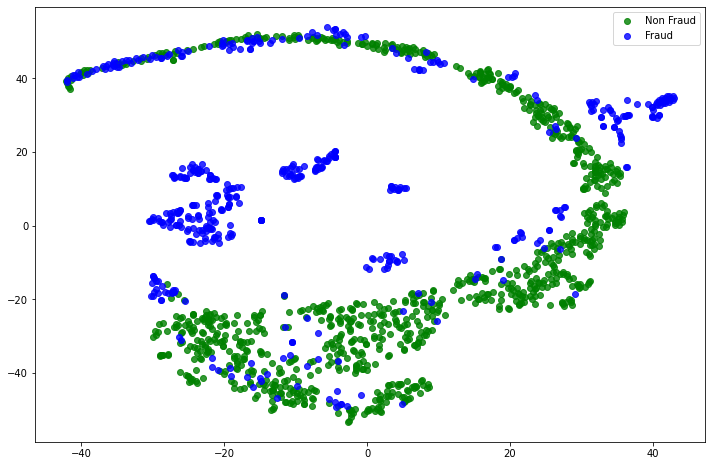

In [ ]:
non_fraud = df[df['Class'] == 0].sample(1000)
fraud = df[df['Class'] == 1]

visualisation_sample = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
tsne_plot(visualisation_sample.drop(['Class'], axis = 1).values, visualisation_sample["Class"].values)

Transform features by scaling each feature to a given range.

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

The transformation is given by:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
where min, max = feature_range.

This transformation is often used as an alternative to zero mean, unit variance scaling.

In [ ]:
df.loc[:, df.columns != 'Class'] = preprocessing.MinMaxScaler().fit_transform(df.loc[:, df.columns != 'Class'].values) # scaling

In [ ]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,0.935,0.766,0.881,0.313,0.763,0.268,0.267,0.786,0.475,0.511,0.252,0.681,0.372,0.636,0.446,0.434,0.737,0.655,0.595,0.583,0.561,0.523,0.664,0.391,0.585,0.395,0.419,0.313,0.006,0
1,0.000,0.979,0.770,0.840,0.272,0.766,0.262,0.265,0.786,0.454,0.505,0.381,0.744,0.486,0.641,0.384,0.464,0.728,0.641,0.552,0.580,0.558,0.480,0.667,0.336,0.587,0.446,0.416,0.313,0.000,0
2,0.000,0.935,0.753,0.868,0.269,0.762,0.281,0.270,0.788,0.411,0.513,0.322,0.707,0.504,0.640,0.512,0.357,0.763,0.645,0.387,0.586,0.565,0.546,0.679,0.289,0.560,0.403,0.415,0.312,0.015,0
3,0.000,0.942,0.765,0.868,0.214,0.766,0.276,0.267,0.789,0.415,0.508,0.272,0.711,0.488,0.636,0.289,0.416,0.711,0.788,0.467,0.578,0.560,0.510,0.663,0.224,0.614,0.389,0.418,0.314,0.005,0
4,0.000,0.939,0.777,0.864,0.270,0.763,0.264,0.269,0.782,0.491,0.524,0.236,0.724,0.553,0.608,0.349,0.435,0.724,0.651,0.626,0.585,0.561,0.547,0.663,0.401,0.566,0.507,0.421,0.317,0.003,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1.000,0.756,0.874,0.667,0.160,0.730,0.237,0.235,0.864,0.529,0.599,0.191,0.806,0.395,0.802,0.267,0.485,0.789,0.688,0.510,0.596,0.565,0.515,0.680,0.314,0.659,0.466,0.434,0.330,0.000,0
284803,1.000,0.946,0.767,0.873,0.219,0.772,0.274,0.266,0.789,0.483,0.489,0.276,0.739,0.542,0.623,0.423,0.427,0.730,0.569,0.443,0.581,0.565,0.553,0.666,0.245,0.544,0.361,0.418,0.312,0.001,0
284804,1.000,0.991,0.764,0.781,0.227,0.783,0.293,0.264,0.793,0.478,0.499,0.310,0.707,0.434,0.629,0.436,0.454,0.740,0.681,0.518,0.580,0.565,0.537,0.665,0.468,0.593,0.411,0.417,0.313,0.003,0
284805,1.000,0.954,0.773,0.850,0.283,0.763,0.269,0.261,0.793,0.476,0.500,0.170,0.668,0.368,0.661,0.483,0.430,0.746,0.730,0.790,0.582,0.566,0.547,0.663,0.399,0.546,0.515,0.419,0.315,0.000,0


#Train Test Split and Exploration #

In [ ]:
test_df = df.sample(30000, random_state = 10) # random validation 30000 samples, used as a test set (approx 10%)
df = df.drop(test_df.index) # our train dataframe now does not contain the test df

In [ ]:
non_fraud_original_samples = df[df['Class'] == 0] # of train set
fraud_original_samples = df[df['Class'] == 1] # of train set

In [ ]:
print('Total Fraud Samples are : ' + str(len(fraud_original_samples)))
print('Total Non Fraud Samples are : ' + str(len(non_fraud_original_samples)))

Total Fraud Samples are : 441
Total Non Fraud Samples are : 254366


# Random Under and OverSampling

In [ ]:
def resample_data(non_fraud, fraud, sample_size, unbalanced=False):
    # A function that receives the fraud and non fraud transcations with the desired sample size per class and returns X and Y
    # doing upsampling and downsampling as necessary
    non_fraud_sample = non_fraud.sample(sample_size + (unbalanced*sample_size*2), random_state=5)
    fraud_sample = fraud.sample(sample_size, random_state=5, replace = (len(fraud) < sample_size))
    df_sample = non_fraud_sample.append(fraud_sample).sample(frac=1).reset_index(drop=True)
    Y_sample = df_sample["Class"].values 
    X_sample = df_sample.drop(['Class'], axis = 1).values
    return X_sample, Y_sample

In [ ]:
def resample_by_SMOTE(X, y, over_percentage = 0.02, under_percentage = 1):
    # A function that balances the dataset according to over and underpercentage using Artificial Sample generation using SMOTE
    over = SMOTE(sampling_strategy=over_percentage)
    under = RandomUnderSampler(sampling_strategy=under_percentage)
    smote_pipeline = Pipeline(steps=[('o', over), ('u', under)])
    return smote_pipeline.fit_resample(X, y)

In [ ]:
# Undersampling Equal size - 441
X_undersample, Y_undersample = resample_data(non_fraud_original_samples, fraud_original_samples, len(fraud_original_samples))
print('Undersampling Data')
print('Non Fraud Samples are : ' + str(np.count_nonzero(Y_undersample == NON_FRAUD)))
print('Fraud Samples are : ' + str(np.count_nonzero(Y_undersample == FRAUD)))

Undersampling Data
Non Fraud Samples are : 441
Fraud Samples are : 441


In [ ]:
X_unbalanced, Y_unbalanced = resample_data(non_fraud_original_samples, fraud_original_samples, len(fraud_original_samples), unbalanced=True)
print('Unbalanced Data 1 to 3')
print('Non Fraud Samples are : ' + str(np.count_nonzero(Y_unbalanced == NON_FRAUD)))
print('Fraud Samples are : ' + str(np.count_nonzero(Y_unbalanced == FRAUD)))

Unbalanced Data
Non Fraud Samples are : 1323
Fraud Samples are : 441


In [ ]:
# Upsampling to - 1000 and downsampling
X_1000, Y_1000 = resample_data(non_fraud_original_samples, fraud_original_samples, 1000)
print('1000 Data Points')
print('Non Fraud Samples are : ' + str(np.count_nonzero(Y_1000 == NON_FRAUD)))
print('Fraud Samples are : ' + str(np.count_nonzero(Y_1000 == FRAUD)))

1000 Data Points
Non Fraud Samples are : 1000
Fraud Samples are : 1000


In [ ]:
# Upsampling to - 2000 and downsampling
X_2000, Y_2000 = resample_data(non_fraud_original_samples, fraud_original_samples, 2000)
print('2000 Data ')
print('Non Fraud Samples are : ' + str(np.count_nonzero(Y_2000 == NON_FRAUD)))
print('Fraud Samples are : ' + str(np.count_nonzero(Y_2000 == FRAUD)))

2000 Data 
Non Fraud Samples are : 2000
Fraud Samples are : 2000


#SMOTE - Synthetic Minority Over-sampling Technique Sampling Experiments

In [ ]:
X_smote_1000_11, Y_smote_1000_11 = resample_by_SMOTE(df.drop(['Class'], axis = 1).values, df['Class'].values, over_percentage = 0.004, under_percentage = 1)
print('SMOTE Data')
print('Non Fraud Samples are : ' + str(np.count_nonzero(Y_smote_1000_11 == NON_FRAUD)))
print('Fraud Samples are : ' + str(np.count_nonzero(Y_smote_1000_11 == FRAUD)))

SMOTE Data
Non Fraud Samples are : 1017
Fraud Samples are : 1017


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_smote_1000_13, Y_smote_1000_13 = resample_by_SMOTE(df.drop(['Class'], axis = 1).values, df['Class'].values, over_percentage = 0.004, under_percentage = 0.33)
print('SMOTE Data')
print('Non Fraud Samples are : ' + str(np.count_nonzero(Y_smote_1000_13 == NON_FRAUD)))
print('Fraud Samples are : ' + str(np.count_nonzero(Y_smote_1000_13 == FRAUD)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTE Data
Non Fraud Samples are : 3081
Fraud Samples are : 1017


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X_smote_1000_110, Y_smote_1000_110 = resample_by_SMOTE(df.drop(['Class'], axis = 1).values, df['Class'].values, over_percentage = 0.004, under_percentage = 0.1)
print('SMOTE Data')
print('Non Fraud Samples are : ' + str(np.count_nonzero(Y_smote_1000_110 == NON_FRAUD)))
print('Fraud Samples are : ' + str(np.count_nonzero(Y_smote_1000_110 == FRAUD)))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


SMOTE Data
Non Fraud Samples are : 10170
Fraud Samples are : 1017


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


# Logistic Regression on Preprocessed Data

In [ ]:
clf_unbalanced = LogisticRegression(random_state=2).fit(X_unbalanced, Y_unbalanced)
predictions_unbalanced = clf_unbalanced.predict(test_df.drop(['Class'], axis = 1).values)
print(classification_report(predictions_unbalanced, test_df["Class"].values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29936
           1       0.82      0.66      0.73        64

    accuracy                           1.00     30000
   macro avg       0.91      0.83      0.86     30000
weighted avg       1.00      1.00      1.00     30000



In [ ]:
clf_under = LogisticRegression(random_state=2).fit(X_undersample, Y_undersample)
predictions_undersample = clf_under.predict(test_df.drop(['Class'], axis = 1).values)
print(classification_report(predictions_undersample, test_df["Class"].values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29872
           1       0.86      0.34      0.49       128

    accuracy                           1.00     30000
   macro avg       0.93      0.67      0.75     30000
weighted avg       1.00      1.00      1.00     30000



In [ ]:
clf_1000 = LogisticRegression(random_state=2).fit(X_1000, Y_1000)
predictions_1000 = clf_1000.predict(test_df.drop(['Class'], axis = 1).values)
print(classification_report(predictions_1000, test_df["Class"].values))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29782
           1       0.90      0.21      0.34       218

    accuracy                           0.99     30000
   macro avg       0.95      0.61      0.67     30000
weighted avg       0.99      0.99      0.99     30000



In [ ]:
clf_2000 = LogisticRegression(random_state=2).fit(X_2000, Y_2000)
predictions_2000 = clf_2000.predict(test_df.drop(['Class'], axis = 1).values)
print(classification_report(predictions_2000, test_df["Class"].values))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29703
           1       0.90      0.15      0.26       297

    accuracy                           0.99     30000
   macro avg       0.95      0.58      0.63     30000
weighted avg       0.99      0.99      0.99     30000



In [ ]:
clf_smote_1000_11 = LogisticRegression(random_state=2).fit(X_smote_1000_11, Y_smote_1000_11)
predictions_smote_1000_11 = clf_smote_1000_11.predict(test_df.drop(['Class'], axis = 1).values)
print(classification_report(predictions_smote_1000_11, test_df["Class"].values))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     29724
           1       0.90      0.17      0.28       276

    accuracy                           0.99     30000
   macro avg       0.95      0.58      0.64     30000
weighted avg       0.99      0.99      0.99     30000



In [ ]:
clf_smote_1000_13 = LogisticRegression(random_state=2).fit(X_smote_1000_13, Y_smote_1000_13)
predictions_smote_1000_13 = clf_smote_1000_13.predict(test_df.drop(['Class'], axis = 1).values)
print(classification_report(predictions_smote_1000_13, test_df["Class"].values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29900
           1       0.86      0.44      0.58       100

    accuracy                           1.00     30000
   macro avg       0.93      0.72      0.79     30000
weighted avg       1.00      1.00      1.00     30000



In [ ]:
clf_smote_1000_110 = LogisticRegression(random_state=2).fit(X_smote_1000_110, Y_smote_1000_110)
predictions_smote_1000_110 = clf_smote_1000_110.predict(test_df.drop(['Class'], axis = 1).values)
print(classification_report(predictions_smote_1000_110, test_df["Class"].values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29939
           1       0.82      0.69      0.75        61

    accuracy                           1.00     30000
   macro avg       0.91      0.84      0.87     30000
weighted avg       1.00      1.00      1.00     30000



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#Autoencoder & Hidden Representations#

In [ ]:
def create_autoencoder(X, enc_layers_size, dec_layers_size, enc_activation_functions, dec_activation_functions, final_activation_function = 'relu', epochs = 10, batch_size = 256):
    # Creates a Tensorflow Sequential model to be used as a Deep Autoencoder for hidden representations
    input_layer = Input(shape=(X.shape[1],))
    
    ## encoding part
    callback = EarlyStopping(monitor = 'val_loss', mode='min', min_delta=0.0001, patience = 5)
    encoded = Dense(enc_layers_size[0], activation = enc_activation_functions[0] , activity_regularizer=regularizers.l1(10e-5))(input_layer) 
    encoded = Dense(enc_layers_size[1], activation = enc_activation_functions[1])(encoded)

    ## decoding part
    decoded = Dense(dec_layers_size[0], activation = dec_activation_functions[0])(encoded)
    decoded = Dense(dec_layers_size[1], activation = dec_activation_functions[1])(decoded)

    ## output layer
    output_layer = Dense(X.shape[1], activation = final_activation_function)(decoded)
    autoencoder = Model(input_layer, output_layer)
    autoencoder.compile(optimizer="adadelta", loss="mse")
    out = autoencoder.fit(X, X, 
                batch_size = batch_size, epochs = epochs, 
                shuffle = True,callbacks=callback, validation_split = 0.10, verbose=False);
    return out, autoencoder

In [ ]:
# establish example model
encoder_data = non_fraud_original_samples.sample(2000).drop(['Class'], axis = 1).to_numpy()
out ,autoencoder = create_autoencoder(
    X = encoder_data,
    enc_layers_size = [100, 50],
    dec_layers_size = [50, 100],
    enc_activation_functions = ['tanh', 'relu'],
    dec_activation_functions = ['tanh', 'tanh'],
    final_activation_function = 'relu',
    epochs = 10,
    batch_size = 256
)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
dense (Dense)                (None, 100)               3100      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
Total params: 18,830
Trainable params: 18,830
Non-trainable params: 0
_________________________________________________________

In [ ]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

# Visualised Example Autoencoded Test Data #

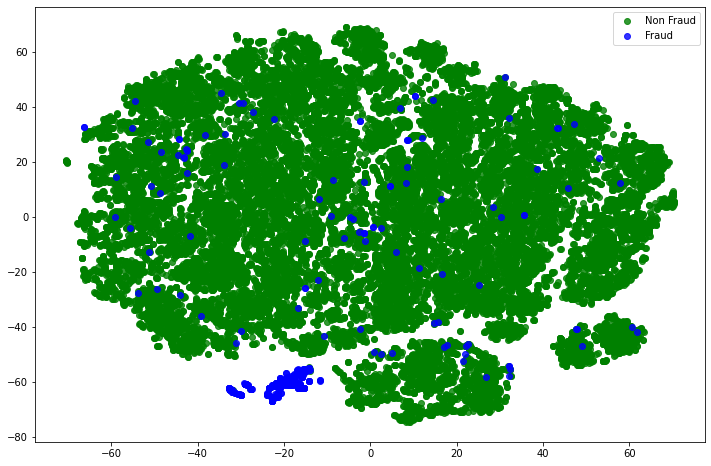

In [ ]:
test_sample = test_df[test_df['Class'] == 0].drop(['Class'], axis = 1).to_numpy()
norm_hid_rep = hidden_representation.predict(test_sample)

fraud_hid_rep = hidden_representation.predict(df[df['Class'] == 1].drop(['Class'], axis = 1).to_numpy())

rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

#Autoencoder experiments#

In [ ]:
def autoencode_and_classify(enc_samples, enc_epochs):
    # Autoencode creation and experiment with Undersampling, Unbalanced (3 to 1) and Oversampling (1000, 2000, 5000)
    encoder_data = non_fraud_original_samples.sample(enc_samples).drop(['Class'], axis = 1).to_numpy()
    out ,autoencoder = create_autoencoder(
        X = encoder_data,
        enc_layers_size = [100, 50],
        dec_layers_size = [50, 100],
        enc_activation_functions = ['tanh', 'relu'],
        dec_activation_functions = ['tanh', 'tanh'],
        final_activation_function = 'relu',
        epochs = enc_epochs,
        batch_size = 256
    )
    # prepare hidden representations
    hidden_representation = Sequential()
    hidden_representation.add(autoencoder.layers[0])
    hidden_representation.add(autoencoder.layers[1])
    hidden_representation.add(autoencoder.layers[2])

    hidden_representation_test = hidden_representation.predict(test_df.drop(['Class'], axis = 1).values)

    unbalanced_train_enc = hidden_representation.predict(X_unbalanced)
    undersample_train_enc = hidden_representation.predict(X_undersample)
    X1000_train_enc = hidden_representation.predict(X_1000)
    X2000_train_enc = hidden_representation.predict(X_2000)
    X1000_13_smote_train_enc = hidden_representation.predict(X_smote_1000_13)
    X1000_110_smote_train_enc = hidden_representation.predict(X_smote_1000_110)

    # Conduct multiple experiments (as per print title)
    print('Classification with Unbalanced Data (3 to 1) \n')
    log_clf_unbalanced = LogisticRegression(solver="lbfgs").fit(unbalanced_train_enc, Y_unbalanced)
    log_clf_unbalanced_predictions = log_clf_unbalanced.predict(hidden_representation_test)
    print(classification_report(log_clf_unbalanced_predictions, test_df["Class"].values))

    print('Classification with Undersampling \n')
    log_clf_under = LogisticRegression(solver="lbfgs").fit(undersample_train_enc, Y_undersample)
    log_clf_under_predictions = log_clf_under.predict(hidden_representation_test)
    print(classification_report(log_clf_under_predictions, test_df["Class"].values))

    print('Classification with Oversampling to 1000 \n')
    log_clf_X1000 = LogisticRegression(solver="lbfgs").fit(X1000_train_enc, Y_1000)
    log_clf_X1000_predictions = log_clf_X1000.predict(hidden_representation_test)
    print(classification_report(log_clf_X1000_predictions, test_df["Class"].values))

    print('Classification with Oversampling to 2000 \n')
    log_clf_X2000 = LogisticRegression(solver="lbfgs").fit(X2000_train_enc, Y_2000)
    log_clf_X2000_predictions = log_clf_X2000.predict(hidden_representation_test)
    print(classification_report(log_clf_X2000_predictions, test_df["Class"].values))

    print('Classification with SMOTE Oversampling to 1000 (1 to 3) \n')
    log_clf_X1000_smote_13 = LogisticRegression(solver="lbfgs").fit(X1000_13_smote_train_enc, Y_smote_1000_13)
    log_clf_X1000_smote_13_predictions = log_clf_X1000_smote_13.predict(hidden_representation_test)
    print(classification_report(log_clf_X1000_smote_13_predictions, test_df["Class"].values))

    print('Classification with SMOTE Oversampling to 1000 (1 to 10) \n')
    log_clf_X1000_smote_110 = LogisticRegression(solver="lbfgs").fit(X1000_110_smote_train_enc, Y_smote_1000_110)
    log_clf_X1000_smote_110_predictions = log_clf_X1000_smote_110.predict(hidden_representation_test)
    print(classification_report(log_clf_X1000_smote_110_predictions , test_df["Class"].values))

In [ ]:
autoencode_and_classify(enc_samples = 2000, enc_epochs = 10)

Classification with Unbalanced Data (3 to 1) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.75      0.81      0.78        47

    accuracy                           1.00     30000
   macro avg       0.87      0.90      0.89     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Undersampling 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29940
           1       0.80      0.68      0.74        60

    accuracy                           1.00     30000
   macro avg       0.90      0.84      0.87     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Oversampling to 1000 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29928
           1       0.80      0.57      0.67        72

    accuracy                           1.00     30000
  

In [ ]:
autoencode_and_classify(enc_samples = 3000, enc_epochs = 10)

Classification with Unbalanced Data (3 to 1) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29954
           1       0.75      0.83      0.78        46

    accuracy                           1.00     30000
   macro avg       0.87      0.91      0.89     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Undersampling 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29907
           1       0.80      0.44      0.57        93

    accuracy                           1.00     30000
   macro avg       0.90      0.72      0.78     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Oversampling to 1000 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29891
           1       0.86      0.40      0.55       109

    accuracy                           1.00     30000
  

In [ ]:
autoencode_and_classify(enc_samples = 5000, enc_epochs = 10)

Classification with Unbalanced Data (3 to 1) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.76      0.83      0.80        47

    accuracy                           1.00     30000
   macro avg       0.88      0.91      0.90     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Undersampling 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29921
           1       0.80      0.52      0.63        79

    accuracy                           1.00     30000
   macro avg       0.90      0.76      0.81     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Oversampling to 1000 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29904
           1       0.82      0.44      0.57        96

    accuracy                           1.00     30000
  

In [ ]:
autoencode_and_classify(enc_samples = 10000, enc_epochs = 10)

Classification with Unbalanced Data (3 to 1) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29954
           1       0.75      0.83      0.78        46

    accuracy                           1.00     30000
   macro avg       0.87      0.91      0.89     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Undersampling 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29867
           1       0.78      0.30      0.43       133

    accuracy                           1.00     30000
   macro avg       0.89      0.65      0.72     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Oversampling to 1000 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29885
           1       0.80      0.36      0.49       115

    accuracy                           1.00     30000
  

In [ ]:
autoencode_and_classify(enc_samples = 30000, enc_epochs = 10)

Classification with Unbalanced Data (3 to 1) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29953
           1       0.78      0.85      0.82        47

    accuracy                           1.00     30000
   macro avg       0.89      0.93      0.91     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Undersampling 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29939
           1       0.82      0.69      0.75        61

    accuracy                           1.00     30000
   macro avg       0.91      0.84      0.87     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Oversampling to 1000 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29913
           1       0.84      0.49      0.62        87

    accuracy                           1.00     30000
  

In [ ]:
autoencode_and_classify(enc_samples = 100000, enc_epochs = 150)

Classification with Unbalanced Data (3 to 1) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29955
           1       0.73      0.82      0.77        45

    accuracy                           1.00     30000
   macro avg       0.86      0.91      0.89     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Undersampling 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29915
           1       0.78      0.47      0.59        85

    accuracy                           1.00     30000
   macro avg       0.89      0.74      0.79     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Oversampling to 1000 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29878
           1       0.78      0.33      0.46       122

    accuracy                           1.00     30000
  

In [ ]:
autoencode_and_classify(enc_samples = 200000, enc_epochs = 150)

Classification with Unbalanced Data (3 to 1) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29955
           1       0.75      0.84      0.79        45

    accuracy                           1.00     30000
   macro avg       0.87      0.92      0.90     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Undersampling 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29913
           1       0.84      0.49      0.62        87

    accuracy                           1.00     30000
   macro avg       0.92      0.75      0.81     30000
weighted avg       1.00      1.00      1.00     30000

Classification with Oversampling to 1000 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29868
           1       0.84      0.33      0.47       132

    accuracy                           1.00     30000
  